<h1><center>Une application de recommandation de contenu</center></h1>

<hr>
<h3><center>Élaboration d’un modèle Content-Based Filtering</center></h3>
<br>

>__Réalisé par : Said Arrazouaki__


>__Encadré par : Addi Ait-Mlouk__

## Introduction

Le filtrage basé sur le contenu consiste à recommander des articles en s’appuyant uniquement sur leurs caractéristiques propres, et non sur les comportements des autres utilisateurs. Concrètement, chaque article est décrit par un « portrait numérique » sous forme de vecteur : deux articles proches dans cet espace vectoriel partagent des thèmes, des mots-clés ou des rubriques similaires. Lorsqu’un utilisateur a consulté un article, on lui propose donc d’autres contenus dont le vecteur est proche de celui qu’il vient de lire.

Dans notre cas, ces vecteurs sont issus d’un apprentissage préalable qui combine le texte et les métadonnées de chaque article. Ils étaient initialement de dimension 250, mais pour alléger les calculs nous utilisons la version réduite articles_embeddings_reduced.pickle qui ne comporte plus que 75 dimensions tout en conservant l’essentiel de l’information (grâce à une réduction de dimension type PCA conservant plus de 98 % de la variance). Pour comparer les articles dans cet espace, nous utiliserons la similarité cosinus, une mesure adaptée aux vecteurs de grande dimension : elle vaut 1 pour deux vecteurs identiques et tend vers 0 lorsque les articles partagent peu de contenu en commun. Ainsi, pour chaque utilisateur, nous pourrons identifier et lui suggérer les articles les plus proches de ceux qu’il a appréciés.

## 1. Chargement des données

Commençons par charger les différentes données nécessaires :
- Le fichier articles_embeddings_reduced.pickle
- Le fichier articles_metadata.csv
- Les fichiers clicks/clicks_hour_*.csv

In [3]:
import pandas as pd
import numpy as np
import pickle
import glob

In [4]:
# Charger les métadonnées des articles
articles_df = pd.read_csv('../data/articles_metadata.csv')
print("Nombre d'articles :", len(articles_df))

Nombre d'articles : 364047


In [5]:
# Charger la matrice d'embeddings des articles
with open('../data/processed/articles_embeddings_reduced.pickle', 'rb') as f:
    embeddings_matrix = pickle.load(f)
print("Taille de la matrice d'embeddings :", embeddings_matrix.shape)

Taille de la matrice d'embeddings : (364047, 75)


In [6]:
embeddings_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-2.176782,1.316913,-1.029048,0.901908,-1.809543,-2.064712,-1.221915,-0.024443,0.927260,-0.669805,...,0.528111,-0.112972,-0.419169,-0.001754,-0.066866,-0.288364,0.166554,-0.091761,0.154860,-0.046834
1,-1.735174,-0.489893,3.268562,0.087855,1.473058,-0.932711,1.841632,-0.881798,-0.207203,0.816809,...,-0.111876,0.144479,0.199041,0.175780,-0.089538,-0.041962,-0.094137,-0.045636,0.174000,-0.216366
2,-0.912689,2.089340,1.865869,-1.202520,2.530599,-0.521971,0.224352,1.479936,-0.191897,1.356800,...,-0.136365,-0.145220,-0.142428,-0.067773,-0.274823,-0.045927,-0.235927,-0.184537,0.233155,0.030380
3,1.096567,-0.212955,4.183517,-0.649575,-0.130866,1.126555,1.063997,-0.662877,0.348141,1.463900,...,0.295610,-0.351968,-0.044041,0.055246,0.292920,0.015151,-0.322508,-0.051290,-0.103305,0.026568
4,0.193785,0.263949,1.896583,-1.834345,1.270376,-1.723297,0.329007,0.283796,-0.659808,1.223740,...,-0.120979,-0.379417,0.106974,-0.154591,0.133175,0.035721,0.055303,-0.038804,0.118085,0.043850


In [7]:
# Charger et concaténer tous les fichiers de clics horaires
clicks_files = glob.glob('../data/clicks/clicks_hour_*.csv')
clicks_list = [pd.read_csv(f) for f in clicks_files]
clicks_df = pd.concat(clicks_list, ignore_index=True)
print("Nombre total de clics :", len(clicks_df))

Nombre total de clics : 2988181


In [ ]:
# lire les user_clicks
with open('../data/processed/user_clicks.pickle', 'rb') as f:
    user_clicks = pickle.load(f)

In [40]:
user_clicks

{0: [157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205],
 1: [235840,
  96663,
  59758,
  160474,
  285719,
  156723,
  205973,
  283392,
  327984,
  183176,
  36162,
  234481],
 2: [119592, 30970, 30760, 209122],
 3: [236065,
  236294,
  234686,
  233769,
  235665,
  235132,
  161178,
  236444,
  234318,
  284985,
  235689,
  236671,
  293114,
  233688,
  237452,
  235745,
  120967],
 4: [48915, 44488, 195887, 195084, 63307, 336499, 271261],
 5: [168868,
  207122,
  286413,
  156543,
  284664,
  156672,
  59929,
  60253,
  160974,
  50864,
  348132,
  284622,
  158082,
  162655,
  284901,
  61741,
  283933,
  282785,
  284664,
  286420,
  156619,
  271551,
  233717,
  158646,
  124228,
  283776,
  286310,
  237257,
  42612,
  159200,
  237356,
  272218,
  202763,
  158642,
  169169,
  286350,
  69433,
  159177,
  202632,
  161801,
  149622,
  159190,
  282917,
  348128,
  348091,
  348135,
  348113,
  348117,
  162663,
  158794,
  348128,
  62631,
  61698,
  36399,
  284090,


## Construction du profil utilisateur

Pour générer des recommandations basées sur le contenu, nous avons besoin d’un profil utilisateur construit à partir des articles qu’il a lus. Nous utilisons pour cela les vecteurs d’embedding associés à ces articles. Deux approches seront testées :

1. Dernier clic : on part du dernier article consulté et on propose des articles qui lui ressemblent.

2. Historique complet : on calcule un vecteur moyen à partir de tous les articles lus (avec ou sans pondération par le nombre de clics) et on recommande les contenus les plus proches de ce profil global

#### Stratégie 1 : Dernier clic

La première stratégie de filtrage basé sur le contenu consiste à recommander des articles similaires au dernier article consulté par l’utilisateur. L’hypothèse est qu’à court terme, ce dernier article reflète son centre d’intérêt immédiat : on lui propose donc des lectures dans le même thème.

In [10]:
def get_user_profile_last_click(user_id):
    """
    Calcule le vecteur de profil de l'utilisateur dans l'espace des embeddings.
    Utilise l'embedding du dernier article cliqué par l'utilisateur.
    """
    if user_id not in user_clicks or len(user_clicks[user_id]) == 0:
        return None
    clicked_articles = user_clicks[user_id]
    last_article_id = clicked_articles[-1]
    
    user_vector = embeddings_matrix.iloc[last_article_id].values
    return user_vector

In [11]:
# Test
example_user = list(user_clicks.keys())[0]
print("Articles consultés par l'utilisateur", example_user, ":", user_clicks[example_user])
print("Vecteur utilisateur (dernière lecture) :\n ", get_user_profile_last_click(example_user))

Articles consultés par l'utilisateur 0 : [157541, 68866, 96755, 313996, 160158, 233470, 87224, 87205]
Vecteur utilisateur (dernière lecture) :
  [ 3.5097826   0.3197432  -2.8272414   1.2147856  -2.4664311   0.75618213
  0.39984334 -0.03059885  1.0965923   1.5024184   0.19609752 -0.6678464
 -1.8609488  -0.17532755  1.4579573   0.17034769 -0.5554228   0.04796061
  0.02243927  0.4893204   1.0710903  -0.2817194   0.1746169   0.44367397
 -0.3509412   1.6358695  -0.18399507 -0.3180685  -0.11830416 -0.47575703
 -0.6972884  -1.6537611  -0.31716073  0.34681767  0.3096094   0.22866894
  0.3064115  -0.36587805  0.37635493 -0.20751148  0.24671033 -1.4426922
  0.36083615 -0.24379197 -0.5290104  -0.47769496  0.43597186 -0.25581273
 -0.36937964  1.0034635  -0.06948723 -0.02474904  0.14468059 -0.33981743
 -0.14640924 -0.21542889  0.40753004  0.9795211   0.60704255  0.25672913
 -0.24450316 -0.16079397 -0.5961052  -0.16017714  0.25987467  0.00523037
  0.0069142  -0.21241808  0.14140403  0.18993519  0.22

#### Stratégie 2 : Historique complet

La seconde stratégie vise à profiler l’utilisateur en utilisant tous les articles qu’il a lus, plutôt que seulement le plus récent. On va calculer un vecteur profil pour l’utilisateur, en faisant la moyenne (pondérée ou non) des vecteurs des articles qu’il a consultés.

Formellement, si $U$ est l’ensemble des articles cliqués par l’utilisateur (par exemple sur une période donnée ou l’ensemble de l’historique), on calcule :

🔹 **Profil non pondéré :**

$$
p = \frac{1}{|U|} \sum_{i \in U} v_i
$$

🔹 **Profil pondéré :**

$$
p_w = \frac{1}{\sum_{i \in U} w_i} \sum_{i \in U} w_i \, v_i
$$

où $w_i$ est un poids associé à l’article $i$, en fonction du nombre de clics de l’utilisateur sur cet article.  
Ici, $w_i$ peut simplement être le nombre de fois que l’utilisateur a cliqué sur l’article $i$, de sorte qu’un article consulté plusieurs fois aura plus d’influence dans le profil.

In [12]:
def get_user_profile_mean(user_id, weighted=False):
    clicked_articles = user_clicks.get(user_id, [])
    if not clicked_articles:
        return None


    vectors = embeddings_matrix.iloc[clicked_articles].values

    if weighted:
        # Pondération par fréquence des clics
        article_counts = pd.Series(clicked_articles).value_counts()
        weights = np.array([article_counts[articles_df.iloc[idx]['article_id']] for idx in clicked_articles])
        user_vector = np.average(vectors, axis=0, weights=weights)
    else:
        user_vector = np.mean(vectors, axis=0)

    return user_vector


## Calcul similarité et recommandation

Une fois que nous avons le vecteur profil de l’utilisateur (noté $u$), nous calculons la similarité cosinus entre ce vecteur et tous les vecteurs d’articles candidats. 

La similarité cosinus entre deux vecteurs $x$ et $y$ est définie par :

$$
\text{sim}(x, y) = \frac{x \cdot y}{\|x\| \, \|y\|}
$$

Cette mesure varie de -1 à 1, où : 1 signifie que les vecteurs sont colinéaires (très similaires en orientation, donc articles très similaires), 0 signifie qu’ils sont orthogonaux (aucune similarité), -1 signifie qu’ils sont de sens opposés (rare dans notre contexte).


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_articles(user_vector, user_id, top_n=5):
    if user_vector is None:
        popular_articles = clicks_df['click_article_id'].value_counts().head(top_n).index.tolist()
        return popular_articles

    similarities = cosine_similarity([user_vector], embeddings_matrix.values)[0]

    # Ignorer les articles déjà vus
    seen_articles = set(user_clicks.get(user_id, []))
    for idx in seen_articles:
        if idx is not None:
            similarities[idx] = -1

    top_indices = similarities.argsort()[::-1][:top_n]
    #recommended_article_ids = articles_df.iloc[top_indices]['article_id'].tolist()
    recommendations = []
    for idx in top_indices:
        art_id = articles_df.iloc[idx]['article_id'] if 'article_id' in articles_df.columns else idx
        recommendations.append((art_id, similarities[idx]))
    return recommendations

In [14]:
def recommend_last_click(user_id, top_n=5):
    user_vector = get_user_profile_last_click(user_id)
    return recommend_articles(user_vector, user_id, top_n)

def recommend_mean_clicks(user_id, top_n=5, weighted=False):
    user_vector = get_user_profile_mean(user_id, weighted)
    return recommend_articles(user_vector, user_id, top_n)


Test des fonctions de recommandations:

In [26]:
# Un utilisateur d'exemple
example_user = list(user_clicks.keys())[0]

In [27]:
# Dernier clic
print("Recommendations pour l'utilisateur", example_user, "avec la strategie dernier clic:")
for art, sim in recommend_last_click(example_user):
    print(f"  Article {art} (similarité = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie dernier clic:
  Article 86143 (similarité = 0.877)
  Article 87427 (similarité = 0.876)
  Article 87676 (similarité = 0.873)
  Article 87278 (similarité = 0.872)
  Article 86613 (similarité = 0.871)


In [28]:
# Historique complet sans pondération
print("Recommendations pour l'utilisateur", example_user, "avec la strategie historique complet sans pondération:")
for art, sim in recommend_mean_clicks(example_user, weighted=False):
    print(f"  Article {art} (similarité = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie historique complet sans pondération:
  Article 161133 (similarité = 0.848)
  Article 162235 (similarité = 0.840)
  Article 161789 (similarité = 0.840)
  Article 159495 (similarité = 0.835)
  Article 107637 (similarité = 0.833)


In [29]:
# Historique complet avec pondération
print("Recommendations pour l'utilisateur", example_user, "avec la strategie historique complet avec pondération:")
for art, sim in recommend_mean_clicks(example_user, weighted=True):
    print(f"  Article {art} (similarité = {sim:.3f})")

Recommendations pour l'utilisateur 0 avec la strategie historique complet avec pondération:


  Article 161133 (similarité = 0.848)
  Article 162235 (similarité = 0.840)
  Article 161789 (similarité = 0.840)
  Article 159495 (similarité = 0.835)
  Article 107637 (similarité = 0.833)


## visualisations

In [30]:
from sklearn.decomposition import PCA

# Réduction de dim avec PCA
pca = PCA(n_components=2)
articles_2D = pca.fit_transform(embeddings_matrix)


# On ajoute les colonnes 2D au dataframe
articles_df['x'] = articles_2D[:, 0]
articles_df['y'] = articles_2D[:, 1]

In [31]:
def mark_articles(user_id, recommended_ids):
    clicked_ids = user_clicks.get(user_id, [])

    articles_df['status'] = 'all'
    articles_df['last_clicked'] = False

    if clicked_ids:
        articles_df.loc[articles_df['article_id'].isin(clicked_ids), 'status'] = 'clicked'
        articles_df.loc[articles_df['article_id'].isin(recommended_ids), 'status'] = 'recommended'
        last_id = clicked_ids[-1]
        articles_df.loc[articles_df['article_id'] == last_id, 'last_clicked'] = True


In [32]:
import matplotlib.pyplot as plt

def plot_user_recommendations(user_id, recommended_ids):
    mark_articles(user_id, recommended_ids)

    plt.figure(figsize=(12, 8))

    # Articles généraux
    df_all = articles_df[articles_df['status'] == 'all']
    plt.scatter(df_all['x'], df_all['y'], c='lightgray', s=10, label='Tous les articles', alpha=0.3)

    # Articles cliqués
    df_clicked = articles_df[(articles_df['status'] == 'clicked') & (~articles_df['last_clicked'])]
    plt.scatter(df_clicked['x'], df_clicked['y'], c='royalblue', s=60, label='Articles cliqués')

    # Recommandés
    df_rec = articles_df[articles_df['status'] == 'recommended']
    plt.scatter(df_rec['x'], df_rec['y'], c='limegreen', s=80, edgecolor='black', linewidths=0.5, label='Recommandations')

    # Dernier clic (point rouge)
    df_last = articles_df[articles_df['last_clicked']]
    plt.scatter(df_last['x'], df_last['y'], c='red', s=120, edgecolor='black', linewidths=1.2, label='Dernier article cliqué', marker='*')

    plt.title(f"Recommandations pour l'utilisateur {user_id}", fontsize=16)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
# Un utilisateur d'exemple
example_user = list(user_clicks.keys())[0]

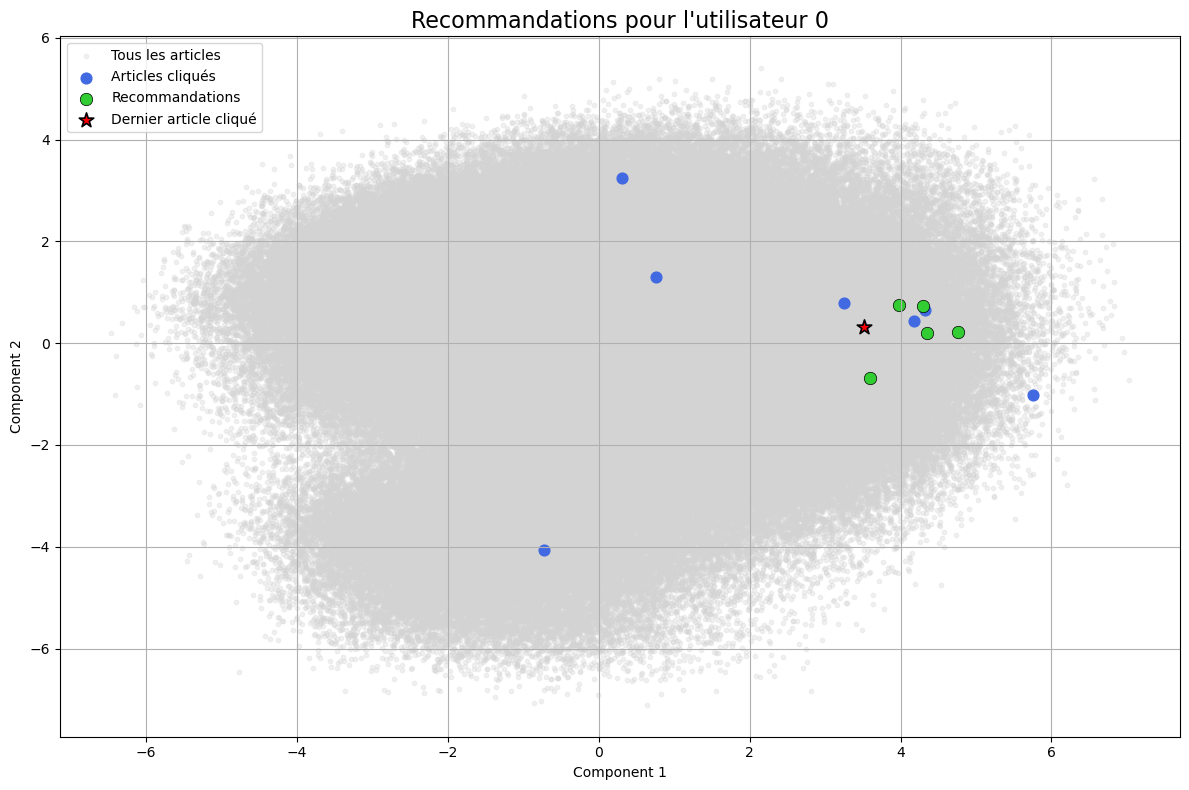

In [34]:
# Recommandations pour l'utilisateur avec la stratégie dernier clic
recommended_ids = []
for art in recommend_last_click(example_user):
    recommended_ids.append(art[0]) 

plot_user_recommendations(example_user, recommended_ids)

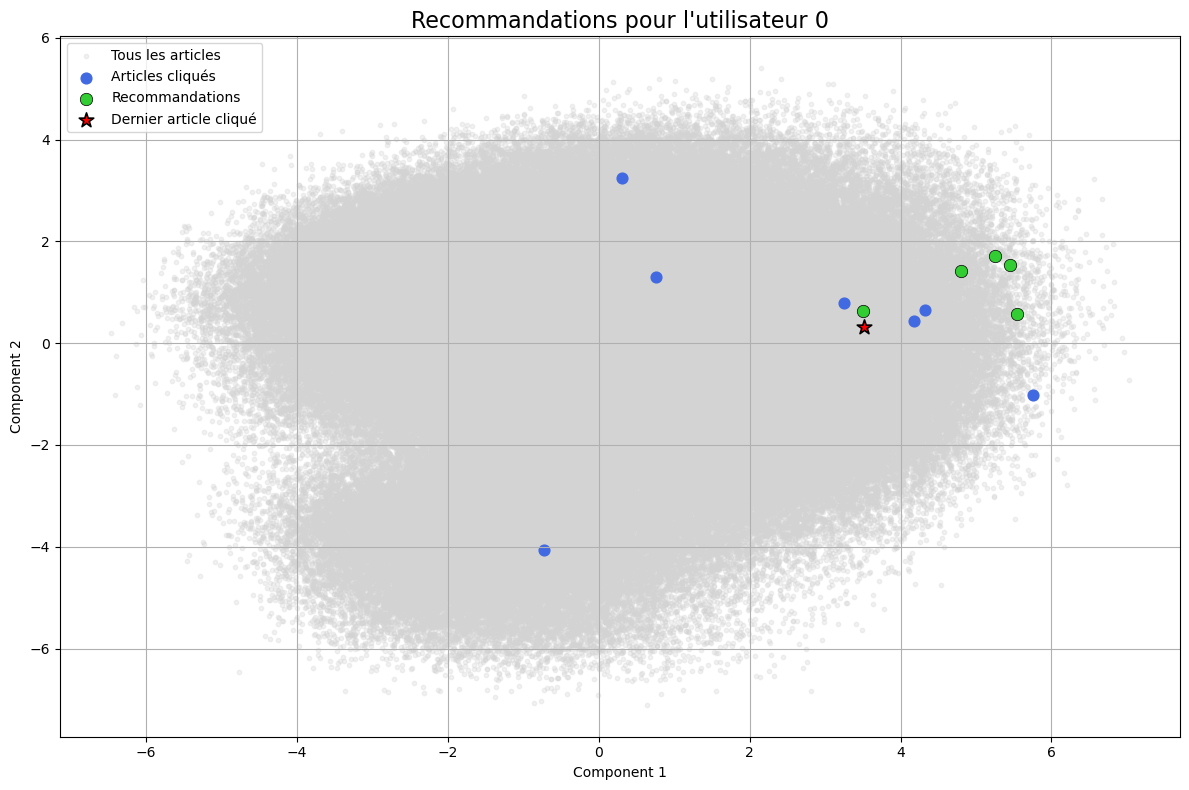

In [35]:
#Recommendations pour l'utilisateur avec la stratégie historique complet sans pondération
recommended_ids = []
for art in recommend_mean_clicks(example_user, weighted=False):
    recommended_ids.append(art[0])
plot_user_recommendations(example_user, recommended_ids)

## Conclusion 

Dans ce premier module, nous avons donc chargé et préparé les données, construit des profils utilisateurs à partir des embeddings et mis en œuvre plusieurs variantes du filtrage basé sur le contenu. Deux fonctions de recommandation ont été développées :

- recommend_last_click(user_id), qui s’appuie uniquement sur le dernier article consulté pour proposer des contenus similaires ;

- recommend_mean_clicks(user_id, weighted=False/True), qui calcule un vecteur moyen à partir de l’ensemble des articles lus, avec la possibilité de pondérer chaque article par sa fréquence de consultation.

Après évaluation, nous retenons pour la mise en production la fonction last click, qui offre un bon compromis entre pertinence et simplicité de calcul. Une fois les embeddings chargés en mémoire, cette approche est très rapide à exécuter et facile à intégrer dans une Azure Function : il suffit de charger les fichiers nécessaires au démarrage et de renvoyer les cinq articles les plus proches en réponse à chaque requête. Les autres variantes restent à disposition pour explorer des stratégies plus fines ou pondérées si cela s’avère nécessaire à l’avenir.